**<h1><center>CS 464</center></h1>**
**<h1><center>Introduction to Machine Learning</center></h1>**
**<h1><center>Spring 2022</center></h1>**
**<h1><center>Homework 3</center></h1>**
<h4><center>Due: DEC 23, 2022 23:59 (GMT+3)</center></h4>

In this third homework assignment, you are asked to develop a system that can be used to supply additional information to weather forecasts. For this task, you are provided a dataset that consists of weather images that belong to four different weather conditions: [cloudy, rain, shiny, sunrise]. Your model will classify images considering these class labels. 

For this assignment, **using PyTorch is mandatory.**

**Tip:** You may experience latencies in file I/O if you are using Google Colab. In this regard, we recommend you upload your data to Google Drive as a zip file and unzip the folder contents in your drive. If you would like to upload the data files separately, it may take significant time.

You will submit a single ipynb file as the homework submission. If you want to provide further explanation about your work, you can add Markdown cells to do so. [Here](https://www.markdownguide.org/), you can find a guide for Markdown syntax. Upload your homework with the following filename convention: \<BilkentID\>\_\<Name\>\_\<Surname\>.ipynb

**Contact:**
- [Yusuf Dalva](mailto:yusuf.dalva@bilkent.edu.tr)
- [Ahmet Burak Yıldırım](mailto:a.yildirim@bilkent.edu.tr)

**Dataset**<br>
You can find the dataset [here](https://www.kaggle.com/datasets/pratik2901/multiclass-weather-dataset). 


# **Q1** [12 points]
This part consists of 4 questions which you are expected to answer. Please fill in the following cell in Markdown format. Each question is worth 2 points.

a) Do we need to output the actual probability values when performing classification with the softmax layer? If not, how do these numbers represent the likelihood of classes? Also, does the output values should be in a specific range for us to make a classification? <br>

    No we do not need to output the actual probability values. Softmax layer transforms the raw output to probability vector that each input takes a value between 0 and 1. These values can be interpreted as likelihood of classes. All output values should sum up to 1, i.e., all values should be in the range (0,1) for us to make a classification.  

b) From the perspective of model complexity, how you can identify when a model underfits or overfits? Which plots are informative for detecting this behavior? <br>

    We can identify overfitting when our model performs too well for training data when it performs poorly for test data that shows that our model is even learned and responding the noisy samples of the training data. Similarly, we can identify when a model underfits when our model performs poorly for both train and test data that shows our model could not learn the patterns in the dataset. Learning curve methods are informative when detecting overfitting or underfitting, if the accuracy/score is low for both train and test on these plots, and the two accuracies are close to each other, we can say the model is underfitting. Similarly, we can say that overfitting occurs when training accuracy is high, or error is low, where test accuracy is low, or the test error is high. 

c) In neural networks, how does the ReLU function help us to generalize to complex feature spaces? Why we are not using linear layers only? <br>

    Since ReLU introduces non-linearity to our neural network model by outputting negative values as 0 and positive values as themselves, it might help our model to generalize more complex features. When we only use linear layers, all the transformations to the input will be linear and our model will only be able to generalize features that can only be addressed by linear functions. However, complexity cannot be captured by using only linear functions, this is why we introduce non-linear layers. Also, I read that "the universal approximation theorem" states that "in order to approach nonlinear problems, there must be some sort of nonlinearity in the network" [1].

d) Assume that you are going to pass the feature matrix with dimensions 64x64x5 (Height x Width x Channel size) through a convolutional layer. If our convolutional layer has a kernel size of 3x3 and the number of filters is 6, how many learnable parameters are present? <br>

    # of Filters * kernel matrix dimensions * channel size = 6 * 9 * 5 = 270, and there are bias terms, one for each filter 6. Total learnable parameter number is 276.
    
    1- A. Ye, "Finally, an intuitive explanation of why ReLU works", Medium. Available: https://towardsdatascience.com/if-rectified-linear-units-are-linear-how-do-they-add-nonlinearity-40247d3e4792

# **Q2** [88 points]

## Necessary Imports
In the cell below, we import some utilities that you can make use of in this assignment. Note that you need to use PyTorch in this assignment. To report certain metrics (like precision, recall, accuracy) you may use utilities from *scikit-learn* library. You can edit these imports considering your implementation as long as you use PyTorch.

## Setup

In [3]:
import os 
import time
import random

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score, ConfusionMatrixDisplay

You can test whether hardware acceleration with GPU is enabled in the cell below. In addition, if you have GPU access, you can check the amount of available GPU memory.

In [4]:
# setting device as GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# CUDA device information
if device.type == 'cuda':
    print('GPU Name:', torch.cuda.get_device_name(0))
    print('Memory Stats:')
    print('  - Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('  - Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
    print('  - Total:    ', round(torch.cuda.get_device_properties(0).total_memory/1024**3,1), 'GB')

Using device: cuda
GPU Name: NVIDIA GeForce GTX 1650
Memory Stats:
  - Allocated: 0.0 GB
  - Cached:    0.0 GB
  - Total:     4.0 GB


**DO NOT CHANGE**<br>
To evaluate your implementation fairly, we set seed values for random sampling methods in PyTorch, Numpy, and Python random library. These seeds are set to evaluate your models successfully, so do not change these values.

In [8]:
# for reproducable results
torch.manual_seed(464)
torch.cuda.manual_seed(464)
np.random.seed(464)
random.seed(464)
if device.type == 'cuda':
    torch.backends.cudnn.deterministic=True

## Load Data [6 points]
In this assignment, you will use a custom dataset, which you need a wrapper class to access its data. For this purpose, implement a custom dataset class to organize data with the specifications you need. This class will load batches of data using a PyTorch DataLoader later. The class signature of CustomDataset class is provided to you in the cell below, where you can implement your custom dataset.

**IMPORTANT:** As you may have difficulties while fitting all images to your RAM, you need to read the images while getting that item (each item is an image here). We encourage you to read the data files in the "__getitem__" function to avoid encountering any issues related to fitting the data to memory. This way, you do not need to hold the dataset in a single variable, which would be memory intensive.

In [11]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None, **kwargs):
        self.root_dir = root_dir
        self.transform = transform
        self.subdirectories = [ d.path for d in os.scandir(self.root_dir) if d.is_dir() ]
        self.data = []
        self.labels = []
        for sub in self.subdirectories:
            file_names = os.listdir(sub)
            for file in file_names:
                self.data.append(os.path.join(sub, file))
                self.labels.append(self.subdirectories.index(sub))

    '''This function should return sample count in the dataset'''
    def __len__(self):
        return len(self.data)

    '''This function should return a single sample and its ground truth value from the dataset corresponding to index parameter '''
    def __getitem__(self, index):
        img = Image.open(self.data[index]).convert("RGB").resize((224, 224))
        
        if self.transform:
            img = self.transform(img)
        return (img, self.labels[index])

You can implement an additional function to read and construct custom dataset objects for training, validation, and test sets. While constructing the dataset, consider the following issues:
- Dataset contains images that end with prefixes *.jpg* and *.jpeg*.
- If you use PIL to read images, you should convert them to "RGB" format to operate on three color channels.
- Resize the dataset images to 224x224. You are going to design models that take images with tensor shape 224x224x3.
- If you wish, you can change the ordering of the color channels with np.moveaxis function

Lastly, the train-validation-test split for the dataset provided to you is 70-10-20 in terms of percentages. While constructing the dataset, remember that shuffling is a necessary step (to get randomly distributed classes across batches).

You can design your dataset getter method compatible with the line provided below, where train_dataset, val_dataset, and test_dataset are all instances of CustomDataset.

In [12]:
data = CustomDataset("Multi-class Weather Dataset", transform=transforms.Compose([transforms.ToTensor(), 
                                                                                  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

no_of_instances = len(data)

test_validation_size = int(no_of_instances * 0.3)
train_size = no_of_instances - test_validation_size
validation_size = int(test_validation_size * 1/3)
test_size = test_validation_size - validation_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(data, [train_size, validation_size, test_size])

## Models [16 points]
In this assignment, you will implement one CNN (Convolutional Neural Network) model and one FCN (Fully-Connected Network) model, where the class signatures are provided below.

### Convolutional Neural Network (CNN) Model [8 points]
As the first model, you will implement a convolutional model. Your model will include 3 CONV + POOL blocks, which denotes one Convolutional layer followed by a Max Pooling Layer. The channel sizes for convolutional blocks are [16, 32, 64], respectively. For all convolutional layers, take kernel size as 3, stride as one, and apply padding such that convolutions do not change the shape on width and height dimensions. 
<br><br>
Following the convolutional part, you will perform image classification for the dataset provided to you. You can use ReLU activation as the non-linearity in your model (except the classification layer).

In [32]:
class ConvNet(nn.Module):
    '''Define your convolutional neural network'''
    def __init__(self, **kwargs):
        super(ConvNet, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding='same')  
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding='same')       
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding='same')
        
        # I chose Max Pooling layers to be kernel size 2, stride 2. I may try different values later
        self.pool = nn.MaxPool2d(2,2)
        
        self.fc = nn.Linear(in_features=64*28*28, out_features=4) # Dimensions reduced to 28*28 and output channel 64, and there are four classes 
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64*28*28)
        x = self.fc(x)
        return x

### Fully Connected Network (FCN) Model [8 points]
The second model you will try is a Fully Connected Network composed of Linear layers and non-linear activation functions connected to each other. For this part, the number of features for your linear layers is [1024, 512, 256]. Again, you can use ReLU as your non-linear activation function in your model (except the classification layer).

In [33]:
class FCNet(nn.Module):
    '''Define your full connected network'''
    def __init__(self, **kwargs):
        super(FCNet, self).__init__()
        
        self.fc1 = nn.Linear(in_features=224*224*3, out_features=1024)
        self.fc2 = nn.Linear(in_features=1024, out_features=512)
        self.fc3 = nn.Linear(in_features=512, out_features=256)
        
        # Classification layer
        self.fc = nn.Linear(in_features=256, out_features=4)
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        
        x = self.fc(x)
        return x

## Training and Evaluation of FCN [22 points]

Now that you implemented the model definition of CNN and FCN, you will train these models with the hyperparameters you chose. The hyperparameters that you may change are listed in the cell below. Using the FCN model defined, train a classifier that predicts weather condition classes specified by the dataset. For the optimizer, use [SGD](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html) optimizer provided by PyTorch. You should try out different hyper-parameters like learning rates, epochs, momentum, and weight decay. For [momentum](https://machinelearningmastery.com/gradient-descent-with-momentum-from-scratch/) and [weight decay](https://paperswithcode.com/method/weight-decay), you can read about these concepts if you are interested.

While training your model, save your best model over different epochs. You must select an appropriate metric to define the best model at a time step. You can implement the training procedure in the cell below. If you want to explain the reasoning behind your metric selection, you can add a markdown cell and provide your comments.

### Training [12 points]

I have decided that 15 epochs are enough (since validation accuracy has become 100%) when the learning rate is 0.05, I also tried learning rates 0.001, 0.01 but 
the best and fastest result achieved with 0.05. The batch size 64 was also optimal because I had memory error when I increased it. I have decreased momentum and weight decay but also the best results were with the default values.

In [34]:
#HINT: note that your training time should not take many days.

#TODO:
#Pick your hyper parameters
max_epoch = 15
train_batch = 64
test_batch = 64
learning_rate = 5e-2
momentum = 0.5
weight_decay = 5e-04

# TODO: training loop + eval
train_loader = DataLoader(dataset=train_dataset, batch_size=train_batch, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=test_batch, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=test_batch, shuffle=True)

fcnet_model = FCNet()
optimizer = torch.optim.SGD(fcnet_model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
loss_function = nn.CrossEntropyLoss()

best_acc = 0 

train_accs = []
val_accs = []
    
train_losses = []
val_losses = []

for epoch in range(max_epoch):
    
    
    # Training phase
    fcnet_model.train()
    
    train_acc = 0
    train_loss = 0
    
    for i, (imgs, labels) in enumerate(train_loader):

        labels = labels.type(torch.LongTensor)
        imgs = Variable(imgs)
        labels = Variable(labels)
        
        optimizer.zero_grad()
        res = fcnet_model(imgs)
        
        loss = loss_function(res, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.cpu().data * imgs.size(0)
        
        _, prediction = torch.max(res.data, 1)
        train_acc += int(torch.sum(prediction==labels.data))
    
    train_acc = train_acc / len(train_loader.dataset)
    
    train_accs.append(train_acc)
    train_losses.append(train_loss)
    
    # Evaluation phase
    fcnet_model.eval()
    
    val_acc = 0
    val_loss = 0
    
    for i, (imgs, labels) in enumerate(val_loader):
        labels = labels.type(torch.LongTensor)
        imgs = Variable(imgs)
        labels = Variable(labels)
        
        optimizer.zero_grad()
        res = fcnet_model(imgs)
        
        loss = loss_function(res, labels)
        loss.backward()
        optimizer.step()
        
        val_loss += loss.cpu().data * imgs.size(0)
        
        _, prediction = torch.max(res.data, 1)
        val_acc += int(torch.sum(prediction==labels.data))
    
    val_acc = val_acc / len(val_loader.dataset)
    
    val_accs.append(val_acc)
    val_losses.append(val_loss)
    
    if best_acc < val_acc:
        torch.save(fcnet_model.state_dict(), 'best_fcnet.model')
        best_acc = val_acc
    
    
    print(f"Epoch {epoch + 1} | Train Loss {train_loss}, Train Acc. {train_acc} | Val. Loss {val_loss}, Val. Acc. {val_acc}")

Epoch 1 | Train Loss 713.4625244140625, Train Acc. 0.6459390862944162 | Val. Loss 65.89662170410156, Val. Acc. 0.7767857142857143
Epoch 2 | Train Loss 422.5211486816406, Train Acc. 0.8096446700507615 | Val. Loss 60.60308837890625, Val. Acc. 0.75
Epoch 3 | Train Loss 357.6550598144531, Train Acc. 0.8401015228426396 | Val. Loss 40.49723815917969, Val. Acc. 0.8571428571428571
Epoch 4 | Train Loss 354.0965881347656, Train Acc. 0.8299492385786802 | Val. Loss 40.541072845458984, Val. Acc. 0.9107142857142857
Epoch 5 | Train Loss 290.52252197265625, Train Acc. 0.8527918781725888 | Val. Loss 42.58583068847656, Val. Acc. 0.8660714285714286
Epoch 6 | Train Loss 199.2192840576172, Train Acc. 0.9098984771573604 | Val. Loss 36.503971099853516, Val. Acc. 0.9196428571428571
Epoch 7 | Train Loss 214.41592407226562, Train Acc. 0.899746192893401 | Val. Loss 40.35324478149414, Val. Acc. 0.875
Epoch 8 | Train Loss 146.69252014160156, Train Acc. 0.932741116751269 | Val. Loss 13.509117126464844, Val. Acc. 0.

### Learning Process Analysis [5 points]
Following the training step, you will now provide accuracy and loss plots over all epochs. For this, provide two plots:
- In the first plot, you will provide the value of the accuracy metric over epochs. Your plot should include two curves, one for the training set and the other for the validation set.
- For the second plot, provide the curve for loss values over epochs. Again your plot should include two curves, where one indicates loss on the training set and the second indicates loss for the validation set.

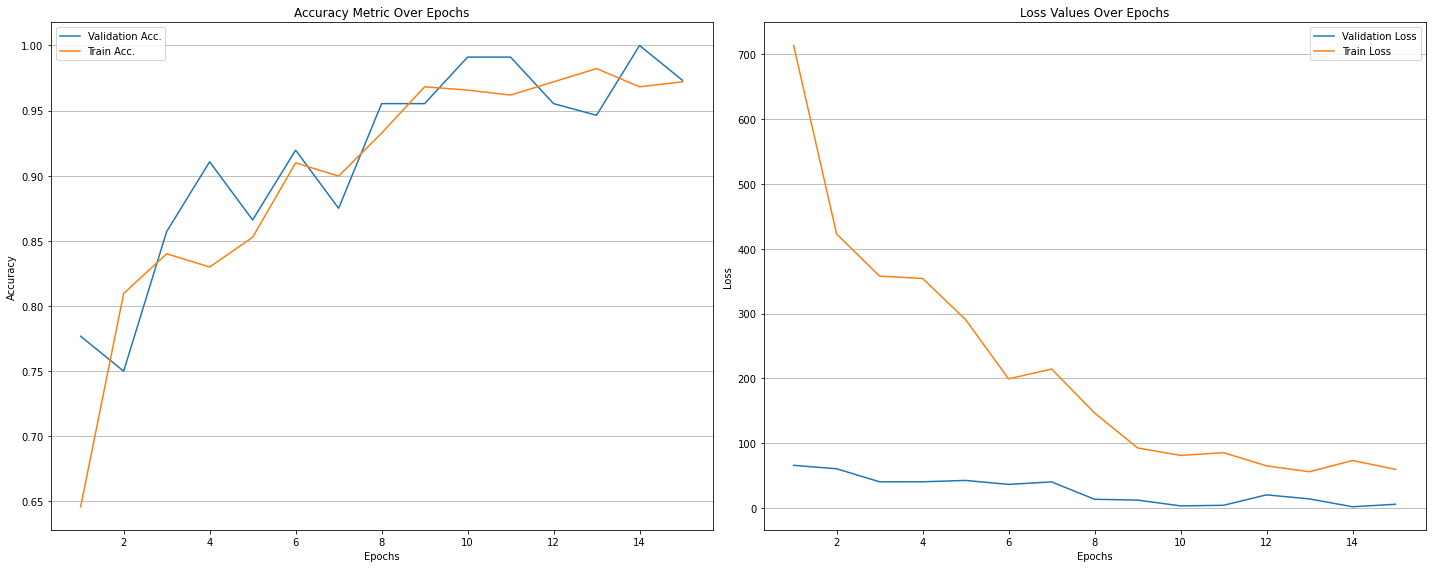

In [35]:
# TODO: Implement your plots here, you can use matplotlib library to do so.
epochs = [ epoch + 1 for epoch in range(max_epoch)]

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))
ax1.plot(epochs, val_accs, label="Validation Acc.")
ax1.plot(epochs, train_accs, label="Train Acc.")
ax1.grid(axis='y')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.set_title('Accuracy Metric Over Epochs')
ax1.legend()

ax2.plot(epochs, val_losses, label="Validation Loss")
ax2.plot(epochs, train_losses, label="Train Loss")
ax2.grid(axis='y')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.set_title('Loss Values Over Epochs')
ax2.legend()

plt.tight_layout()

### Test [5 points]
As the final step of your analysis, you will test your model using some metrics. For the best model you obtained during training, evaluate your model on the test set. Then, report the confusion matrix. Finally, report accuracy, precision, recall, and $F_1$ score using your model. Report all these metrics using the macro form (macro precision, macro recall, etc.). You can implement these metrics in the cell below. 

In [36]:
# TODO: Implement your evaluation script here, provide the confusion matrix and the requested metrics

test_fcnet = FCNet()
test_fcnet.load_state_dict(torch.load('best_fcnet.model'))

test_fcnet.eval()

test_acc = 0

final_preds = []
true_labels = []

for i, (imgs, labels) in enumerate(test_loader):
    labels = labels.type(torch.LongTensor)
    imgs = Variable(imgs)
    labels = Variable(labels)
        
    res = test_fcnet(imgs)
    _, prediction = torch.max(res.data, 1)
    final_preds += prediction
    true_labels += labels
    
final_preds = np.array(final_preds)
true_labels = np.array(true_labels)

--- Metrics for Test Dataset ---
Accuracy: 0.8533333333333334
Macro Precision: 0.8400346458139941
Macro Recall: 0.8408867876914342
Macro F1: 0.8394035628605144


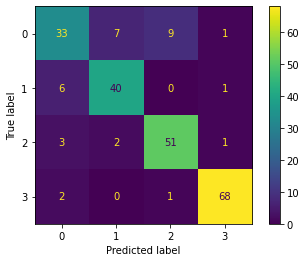

In [37]:
classes = [0, 1, 2, 3]
cm = confusion_matrix(true_labels, final_preds, labels=classes)

accuracy = accuracy_score(true_labels, final_preds)
precision_macro = precision_score(true_labels, final_preds, labels=classes, average='macro')
recall_macro = recall_score(true_labels, final_preds, labels=classes, average='macro')
f1_score_macro = f1_score(true_labels, final_preds, labels=classes, average='macro')

print("--- Metrics for Test Dataset ---")
print(f"Accuracy: {accuracy}")
print(f"Macro Precision: {precision_macro}")
print(f"Macro Recall: {recall_macro}")
print(f"Macro F1: {f1_score_macro}")

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot()
plt.show()

## Training and evaluation of CNN [22 points]
Similar to the FCN model, you will now train the CNN model that you defined before. Again you are free to try out different hyperparameters. This model also will classify weather images with the four classes provided by the dataset. As the optimizer, again, use the SGD implementation provided by PyTorch. You can implement the training loop in the following cell. 

Similar to the training procedure, you need to save the best model you obtain during training. Select an appropriate criterion (metric) to save the best model. If you wish, you can add a markdown cell to explain your reasoning.

### Training [12 points]

In [38]:
#HINT: note that your training time should not take many days.

#TODO:
#Pick your hyper parameters
# I chose max epoch as 20 since the CNN gave the close results to FCN at this epoch no.
max_epoch = 20
train_batch = 64
test_batch = 64
learning_rate = 5e-2
momentum = 0.5
weight_decay = 5e-04

# TODO: training loop + eval
train_loader = DataLoader(dataset=train_dataset, batch_size=train_batch, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=test_batch, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=test_batch, shuffle=True)

cnn_model = ConvNet()
optimizer = torch.optim.SGD(cnn_model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
loss_function = nn.CrossEntropyLoss()

best_acc = 0 

train_accs = []
val_accs = []
    
train_losses = []
val_losses = []

for epoch in range(max_epoch):
    
    
    # Training phase
    cnn_model.train()
    
    train_acc = 0
    train_loss = 0
    
    for i, (imgs, labels) in enumerate(train_loader):

        labels = labels.type(torch.LongTensor)
        imgs = Variable(imgs)
        labels = Variable(labels)
        
        optimizer.zero_grad()
        res = cnn_model(imgs)
        
        loss = loss_function(res, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.cpu().data * imgs.size(0)
        
        _, prediction = torch.max(res.data, 1)
        train_acc += int(torch.sum(prediction==labels.data))
    
    train_acc = train_acc / len(train_loader.dataset)
    
    train_accs.append(train_acc)
    train_losses.append(train_loss)
    
    # Evaluation phase
    cnn_model.eval()
    
    val_acc = 0
    val_loss = 0
    
    for i, (imgs, labels) in enumerate(val_loader):
        labels = labels.type(torch.LongTensor)
        imgs = Variable(imgs)
        labels = Variable(labels)
        
        optimizer.zero_grad()
        res = cnn_model(imgs)
        
        loss = loss_function(res, labels)
        loss.backward()
        optimizer.step()
        
        val_loss += loss.cpu().data * imgs.size(0)
        
        _, prediction = torch.max(res.data, 1)
        val_acc += int(torch.sum(prediction==labels.data))
    
    val_acc = val_acc / len(val_loader.dataset)
    
    val_accs.append(val_acc)
    val_losses.append(val_loss)
    
    if best_acc < val_acc:
        torch.save(cnn_model.state_dict(), 'best_cnn.model')
        best_acc = val_acc
    
    
    print(f"Epoch {epoch + 1} | Train Loss {train_loss}, Train Acc. {train_acc} | Val. Loss {val_loss}, Val. Acc. {val_acc}")

Epoch 1 | Train Loss 918.2716064453125, Train Acc. 0.43147208121827413 | Val. Loss 84.60171508789062, Val. Acc. 0.5982142857142857
Epoch 2 | Train Loss 591.1679077148438, Train Acc. 0.7055837563451777 | Val. Loss 76.1713638305664, Val. Acc. 0.7321428571428571
Epoch 3 | Train Loss 412.7193603515625, Train Acc. 0.8058375634517766 | Val. Loss 50.107295989990234, Val. Acc. 0.7767857142857143
Epoch 4 | Train Loss 321.4186096191406, Train Acc. 0.8477157360406091 | Val. Loss 36.838592529296875, Val. Acc. 0.8660714285714286
Epoch 5 | Train Loss 263.0010070800781, Train Acc. 0.8769035532994924 | Val. Loss 31.424617767333984, Val. Acc. 0.8660714285714286
Epoch 6 | Train Loss 288.16180419921875, Train Acc. 0.8515228426395939 | Val. Loss 44.34275817871094, Val. Acc. 0.8303571428571429
Epoch 7 | Train Loss 208.39346313476562, Train Acc. 0.9137055837563451 | Val. Loss 24.306941986083984, Val. Acc. 0.9107142857142857
Epoch 8 | Train Loss 158.74867248535156, Train Acc. 0.9302030456852792 | Val. Loss 9

### Learning Process Analysis [3 points]
Repeating the same procedure you applied for the FCN model; you will provide two plots about how your training proceeds over epochs. Again, provide two plots: one summarizes the loss values, and the other summarizes the accuracy values. Note that each plot needs to include two curves, one for the validation set and the other for the training set.

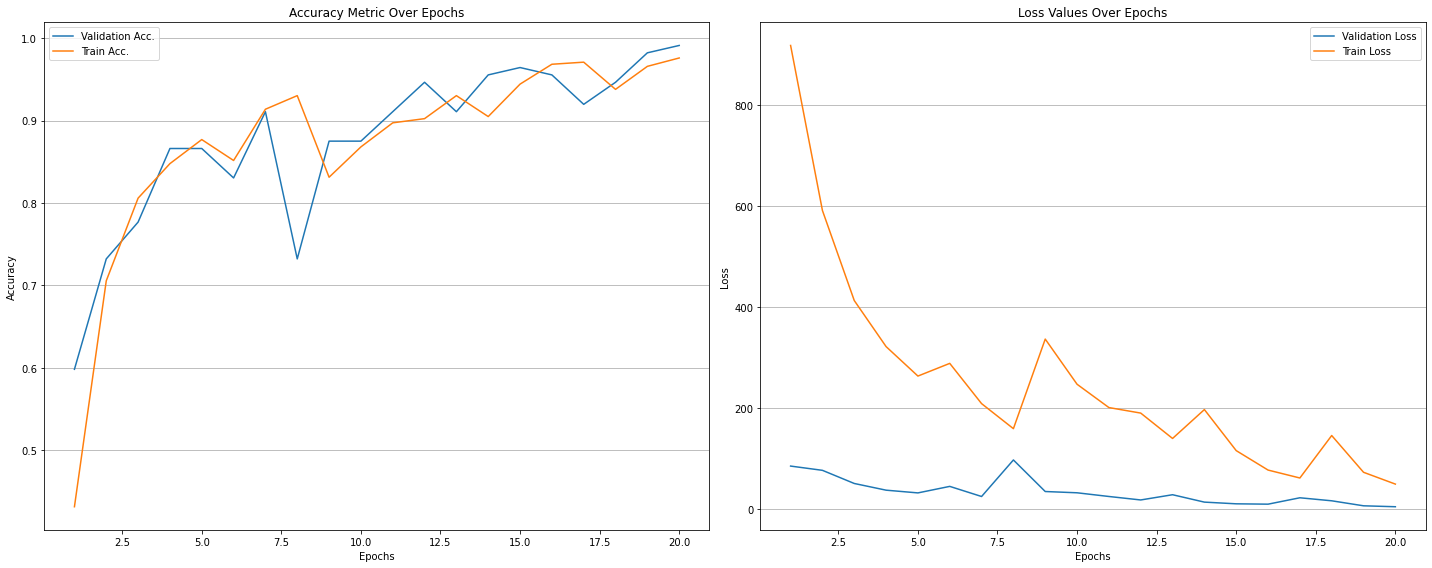

In [39]:
# TODO: Implement your plots here, you can use matplotlib library to do so.
epochs = [ epoch + 1 for epoch in range(max_epoch)]

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))
ax1.plot(epochs, val_accs, label="Validation Acc.")
ax1.plot(epochs, train_accs, label="Train Acc.")
ax1.grid(axis='y')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.set_title('Accuracy Metric Over Epochs')
ax1.legend()

ax2.plot(epochs, val_losses, label="Validation Loss")
ax2.plot(epochs, train_losses, label="Train Loss")
ax2.grid(axis='y')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.set_title('Loss Values Over Epochs')
ax2.legend()

plt.tight_layout()

### Test [4 points]
Concluding your analysis, report the confusion matrix for the best model you obtained during your CNN model training. Then using this confusion matrix, report accuracy, recall, precision, and $F_1$ score for your best model. Use macro averaging in all of your metrics.

In [40]:
# TODO: Implement your evaluation script here, provide the confusion matrix and the requested metrics

test_cnn = ConvNet()
test_cnn.load_state_dict(torch.load('best_cnn.model'))

test_cnn.eval()

test_acc = 0

final_preds = []
true_labels = []

for i, (imgs, labels) in enumerate(test_loader):
    labels = labels.type(torch.LongTensor)
    imgs = Variable(imgs)
    labels = Variable(labels)
        
    res = test_cnn(imgs)
    _, prediction = torch.max(res.data, 1)
    final_preds += prediction
    true_labels += labels
    
final_preds = np.array(final_preds)
true_labels = np.array(true_labels)

--- Metrics for Test Dataset ---
Accuracy: 0.8933333333333333
Macro Precision: 0.8880959614292027
Macro Recall: 0.8805169839492348
Macro F1: 0.8830958881680013


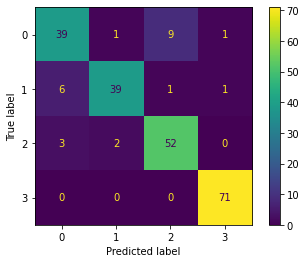

In [41]:
classes = [0, 1, 2, 3]
cm = confusion_matrix(true_labels, final_preds, labels=classes)

accuracy = accuracy_score(true_labels, final_preds)
precision_macro = precision_score(true_labels, final_preds, labels=classes, average='macro')
recall_macro = recall_score(true_labels, final_preds, labels=classes, average='macro')
f1_score_macro = f1_score(true_labels, final_preds, labels=classes, average='macro')

print("--- Metrics for Test Dataset ---")
print(f"Accuracy: {accuracy}")
print(f"Macro Precision: {precision_macro}")
print(f"Macro Recall: {recall_macro}")
print(f"Macro F1: {f1_score_macro}")

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot()
plt.show()

### Discussion [3 points]
Now, try to compare the two models that you trained. How different are these two models regarding the number of parameters used?

Explain your findings by connecting them with your experimental results. You can include your comments on a separate Markdown cell or below the question statement.

Answer: The CNN model was more complex since it had both convolutional and max pooling layers whereas FCN only had 3 fully connected layers. However, both models performed well in the dataset but since CNN was more complex it took more time to train it. I thought that CNN would have higher accuracy but the results were pretty close and FCN took less epochs to produce lower losses. I read that CNN can be used for more complex tasks such as object detection and create multiple outputs, but both FCN and CNN is suitable for image classification. I believe this is why both models performed well.  

## Transfer Learning [22 points]

As the last part of this assignment, you will practice transfer learning. In this methodology, we aim to use models trained on large-scale datasets for our task. As we do not have access to large datasets and computational resources all the time, we sometimes try to use already trained models (on other datasets) as a good starting point for our model, and then fine-tune the weights considering our task.  

Torchvision library provides numerous models pretrained for specific tasks. [Here](https://pytorch.org/vision/stable/models.html), you can find a list of pretrained models. For this part, you will include [ResNet](https://arxiv.org/abs/1512.03385)-18 model, pretrained with ImageNet dataset. ImageNet is a large dataset where training from scratch would take a long time. You will fine-tune this pretrained module for your task. 
<br>
**Hint:** You can add a Linear layer to adapt the model to the number of classes needed for your task. You can access the number of inputs to the ResNet-18 model as $\texttt{model.fc.in_features}$ and then modify the fully connected layer of the model $\texttt{model.fc}$.
<br>

Using the ResNet-18 backbone, implement this model's training loop (by adapting it to your task). You can implement the training procedure in the cell provided below. Again save your model based on a criterion indicating the best model. Explain the reasoning for your criteria. Use the SGD optimizer provided by PyTorch to optimize your model.

Just like the previous parts, you can also tune your hyperparameters to optimize your model's performance. 

### Training [12 points]

In [23]:
# Take a look at in features
resnet_model = models.resnet18(pretrained=True)
print(resnet_model.fc.in_features)

#HINT: note that your training time should not take many days.

#TODO:
#Pick your hyper parameters
max_epoch = 10
train_batch = 64
test_batch = 64
learning_rate = 9e-2
weight_decay = 5e-04

# TODO: Implement training loop + eval using ResNet-18 model
train_loader = DataLoader(dataset=train_dataset, batch_size=train_batch, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=test_batch, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=test_batch, shuffle=True)

for params in resnet_model.parameters():
    params.requires_grad = False
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, 4)

optimizer = torch.optim.SGD(resnet_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
loss_function = nn.CrossEntropyLoss()

best_acc = 0 

train_accs = []
val_accs = []
    
train_losses = []
val_losses = []

for epoch in range(max_epoch):
    
    
    # Training phase
    resnet_model.train()
    
    train_acc = 0
    train_loss = 0
    
    for i, (imgs, labels) in enumerate(train_loader):

        labels = labels.type(torch.LongTensor)
        imgs = Variable(imgs)
        labels = Variable(labels)
        
        optimizer.zero_grad()
        res = resnet_model(imgs)
        
        loss = loss_function(res, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.cpu().data * imgs.size(0)
        
        _, prediction = torch.max(res.data, 1)
        train_acc += int(torch.sum(prediction==labels.data))
    
    train_acc = train_acc / len(train_loader.dataset)
    
    train_accs.append(train_acc)
    train_losses.append(train_loss)
    
    # Evaluation phase
    resnet_model.eval()
    
    val_acc = 0
    val_loss = 0
    
    for i, (imgs, labels) in enumerate(val_loader):
        labels = labels.type(torch.LongTensor)
        imgs = Variable(imgs)
        labels = Variable(labels)
        
        optimizer.zero_grad()
        res = resnet_model(imgs)
        
        loss = loss_function(res, labels)
        loss.backward()
        optimizer.step()
        
        val_loss += loss.cpu().data * imgs.size(0)
        
        _, prediction = torch.max(res.data, 1)
        val_acc += int(torch.sum(prediction==labels.data))
    
    val_acc = val_acc / len(val_loader.dataset)
    
    val_accs.append(val_acc)
    val_losses.append(val_loss)
    
    if best_acc < val_acc:
        torch.save(resnet_model.state_dict(), 'best_resnet.model')
        best_acc = val_acc
    
    
    print(f"Epoch {epoch + 1} | Train Loss {train_loss}, Train Acc. {train_acc} | Val. Loss {val_loss}, Val. Acc. {val_acc}")

512
Epoch 1 | Train Loss 4846.41845703125, Train Acc. 0.41878172588832485 | Val. Loss 408.1501159667969, Val. Acc. 0.44642857142857145
Epoch 2 | Train Loss 537.8589477539062, Train Acc. 0.8413705583756346 | Val. Loss 25.690567016601562, Val. Acc. 0.9196428571428571
Epoch 3 | Train Loss 273.7091979980469, Train Acc. 0.8972081218274112 | Val. Loss 8.63199234008789, Val. Acc. 0.9732142857142857
Epoch 4 | Train Loss 83.43867492675781, Train Acc. 0.9631979695431472 | Val. Loss 16.897300720214844, Val. Acc. 0.9553571428571429
Epoch 5 | Train Loss 85.39480590820312, Train Acc. 0.9619289340101523 | Val. Loss 5.8331732749938965, Val. Acc. 1.0
Epoch 6 | Train Loss 85.78215026855469, Train Acc. 0.9555837563451777 | Val. Loss 6.6569952964782715, Val. Acc. 0.9732142857142857
Epoch 7 | Train Loss 60.25117492675781, Train Acc. 0.9695431472081218 | Val. Loss 7.813143253326416, Val. Acc. 0.9732142857142857
Epoch 8 | Train Loss 111.85225677490234, Train Acc. 0.9441624365482234 | Val. Loss 32.34395599365

## Learning Process Analysis [3 points]
After training your model, provide two plots summarizing the learning procedure. Like previous parts, you will provide plots for loss value and accuracy progression over epochs. Remember that for each plot, you need to include two curves (one for the training set and one for the validation set).

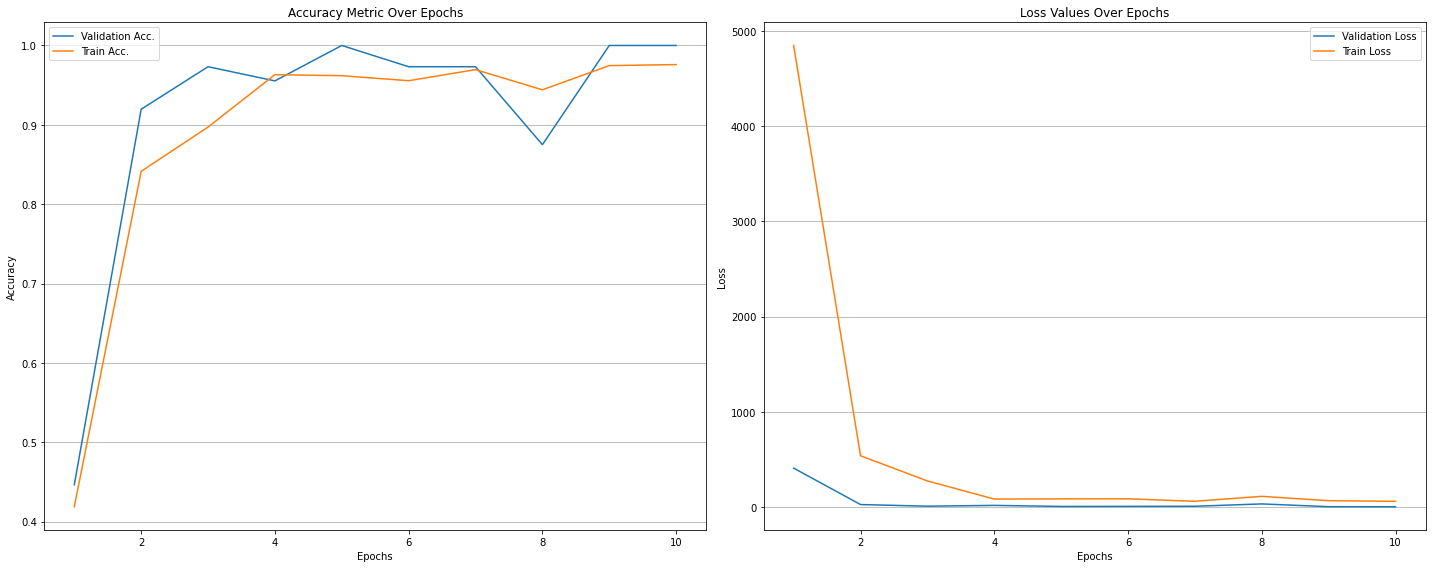

In [24]:
# TODO: Implement your plots here, you can use matplotlib library to do so.
epochs = [ epoch + 1 for epoch in range(max_epoch)]

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))
ax1.plot(epochs, val_accs, label="Validation Acc.")
ax1.plot(epochs, train_accs, label="Train Acc.")
ax1.grid(axis='y')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.set_title('Accuracy Metric Over Epochs')
ax1.legend()

ax2.plot(epochs, val_losses, label="Validation Loss")
ax2.plot(epochs, train_losses, label="Train Loss")
ax2.grid(axis='y')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.set_title('Loss Values Over Epochs')
ax2.legend()

plt.tight_layout()

### Test [4 points]
Following your analysis, report the confusion matrix for the best model you obtained (with the criteria you defined). Then, report the accuracy, precision, recall and $F_1$ score for the best model. In all of the metrics, use macro averaging.

--- Metrics for Test Dataset ---
Accuracy: 0.9511111111111111
Macro Precision: 0.951330625261
Macro Recall: 0.949524785893412
Macro F1: 0.9492773667885454


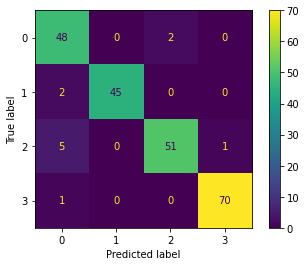

In [27]:
# TODO: Implement your evaluation script here, provide the confusion matrix and the requested metrics
test_resnet = models.resnet18(pretrained=True)
for params in test_resnet.parameters():
    params.requires_grad = False
test_resnet.fc = nn.Linear(test_resnet.fc.in_features, 4)

test_resnet.load_state_dict(torch.load('best_resnet.model'))
test_resnet.eval()

test_acc = 0

final_preds = []
true_labels = []

for i, (imgs, labels) in enumerate(test_loader):
    labels = labels.type(torch.LongTensor)
    imgs = Variable(imgs)
    labels = Variable(labels)
        
    res = test_resnet(imgs)
    _, prediction = torch.max(res.data, 1)
    final_preds += prediction
    true_labels += labels
    
final_preds = np.array(final_preds)
true_labels = np.array(true_labels)
classes = [0, 1, 2, 3]
cm = confusion_matrix(true_labels, final_preds, labels=classes)

accuracy = accuracy_score(true_labels, final_preds)
precision_macro = precision_score(true_labels, final_preds, labels=classes, average='macro')
recall_macro = recall_score(true_labels, final_preds, labels=classes, average='macro')
f1_score_macro = f1_score(true_labels, final_preds, labels=classes, average='macro')

print("--- Metrics for Test Dataset ---")
print(f"Accuracy: {accuracy}")
print(f"Macro Precision: {precision_macro}")
print(f"Macro Recall: {recall_macro}")
print(f"Macro F1: {f1_score_macro}")

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot()
plt.show()

### Discussion [3 points]
Now discuss the effectiveness of Transfer Learning. How does it improve performance?  

Answer: Since this model was trained with a huge dataset, its predictions were pretty accurate in both test and validation tests. It aldready learned the features required to classify these images. The loss of training dataset decreased dramatically compared to FCN and CNN in less number of epochs. Also it was faster since we only trained the last layer (the linear layer that we added).

# References
[1] Ajayi, Gbeminiyi (2018), “Multi-class Weather Dataset for Image Classification”, Mendeley Data, V1, doi: 10.17632/4drtyfjtfy.1